In [2]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("../iGMRF.jl");
include("../dataGen.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [24]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;

In [25]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

In [26]:
grid_target[:, :, 2]

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [27]:
grid_target[:, :, 3]

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [28]:
nobs = 100;
data = generateData(grid_target, nobs);

In [29]:
data

9-element Vector{Vector{Float64}}:
 [12.240682784141626, 9.621417291612469, 9.754494171763968, 12.271969563649202, 9.010088679836304, 10.37854664173395, 9.953170110473183, 9.445009003021907, 9.742009013625772, 9.570691209584776  …  10.518164573659204, 9.930013357326203, 10.282186137930879, 12.850825190676971, 11.539774471964721, 9.408520146607469, 10.911372616309231, 8.729801983142732, 8.72967686719628, 11.836572621374048]
 [11.273789202970812, 8.631556095806973, 13.163945842014405, 11.344148819126897, 9.546754812779685, 10.288636123061432, 8.323184365488917, 11.519918761572495, 10.633947875839283, 9.701374233994922  …  11.842867771041316, 10.125426468920546, 10.559271503126375, 11.915013128851271, 11.83414170304287, 10.090763718674232, 9.618733796527398, 11.037493453323496, 12.569207209872223, 10.34323657298342]
 [10.84714848560555, 10.09386643901673, 11.374159042999196, 10.054626371286963, 11.072357692987763, 9.28577559547066, 11.744733738776487, 9.621447951938798, 9.092795759344487,

# Modèle 

In [30]:
include("NUTS.jl");

niter = 1000;
θ₀ = vcat([50], fill(0, m))
F = iGMRF(m₁, m₂, 0)
nchains = 1;

θ = nuts(niter, θ₀, Y=data, F=F);
κᵤ = θ.value[:, 1, 1];
μ = θ[:, 2:end, 1];

warming_size = Int(0.2 * niter)

newθ = θ[warming_size:end, :, :];
κ̂ᵤ = mean(newθ.value[:, 1, 1]);
μ̂ = mean(newθ.value[:, 2:end, 1], dims=1);

In [31]:
changerate(newθ).value

11×1×1 Array{Float64, 3}:
[:, :, 1] =
 0.565
 0.565
 0.565
 0.565
 0.565
 0.565
 0.565
 0.565
 0.565
 0.565
 0.565

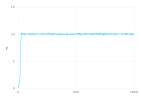

In [32]:
plot(y=μ.value[:, 1, 1], Geom.line)

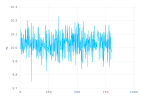

In [33]:
plot(y=newθ.value[:, 2, 1], Geom.line)

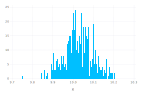

In [34]:
plot(x=newθ.value[:, 2, 1], Geom.histogram)

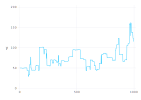

In [35]:
plot(y=κᵤ, Geom.line)

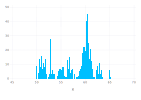

In [15]:
plot(x=κᵤ, Geom.histogram)

In [16]:
κ̂ᵤ

58.82197611611046

In [17]:
summarystats(newθ)

        Mean         SD       Naive SE        MCSE         ESS   
  κᵤ 58.8219761 3.035855016 0.1072666627 0.90021155439  11.372944
  μ1 10.0933671 0.074353541 0.0026271532 0.00295324500 633.876073
  μ2 10.1242381 0.064810622 0.0022899707 0.00307505177 444.209167
  μ3 10.0758658 0.067344501 0.0023795009 0.00220379690 801.000000
  μ4 10.0906139 0.067985347 0.0024021441 0.00303666074 501.231190
  μ5 10.0742223 0.065627806 0.0023188445 0.00304720771 463.843688
  μ6 10.0712056 0.068910580 0.0024348356 0.00438385572 247.092355
  μ7 10.0073194 0.062239362 0.0021991197 0.00181338970 801.000000
  μ8  9.9650372 0.067136444 0.0023721496 0.00269613169 620.061079
  μ9 10.0129704 0.061539894 0.0021744052 0.00244400507 634.029237
 μ10  9.9824837 0.074953706 0.0026483590 0.00237481589 801.000000
 μ11 10.0851762 0.063899805 0.0022577886 0.00261861705 595.463423
 μ12 10.0813968 0.057704546 0.0020388899 0.00235576749 600.005463
 μ13 10.0272472 0.058305787 0.0020601337 0.00060922930 801.000000
 μ14  9.98

In [18]:
reshape(μ̂, m₁, m₂)'

10×10 adjoint(::Matrix{Float64}) with eltype Float64:
 10.0934   10.1242   10.0759   10.0906   …   9.96504  10.013     9.98248
 10.0852   10.0814   10.0272    9.98977      9.95864   9.99485  10.0421
 10.1182   10.0261    9.94858   9.9823      10.0225   10.0654   10.0564
 10.1002    9.95517   9.95918  10.0156      10.0549   10.0748   10.0407
  9.93663   9.94644   9.95373  10.0472      10.0332   10.0494    9.97814
  9.92422   9.89441   9.95512  10.0014   …  10.0265   10.0505   10.0133
  9.96376   9.91404   9.91496   9.92202      9.9532    9.96931   9.95357
  9.9264    9.91907   9.86674   9.90156      9.94338   9.91026   9.9823
 10.0174   10.0034    9.91203   9.88786      9.88946   9.8642    9.8702
 10.0775   10.0303    9.98342   9.90836      9.93128   9.95514   9.8433

In [19]:
grid_target[:, :, 1]

10×10 Matrix{Float64}:
 10.0883   10.1215   10.0313   10.1106   …  10.0192   10.013     9.9882
 10.093    10.0994   10.0888   10.026        9.95252   9.99376  10.0553
 10.0916   10.0074    9.89158   9.94742     10.0047   10.0734   10.087
 10.0949    9.90395   9.93676   9.95348     10.1303   10.0289   10.0361
  9.99375   9.9848    9.96131  10.0436      10.0975   10.0828    9.94785
  9.9527    9.93849  10.0105   10.0239   …  10.0303   10.1027    9.97924
  9.96223   9.89523   9.99495   9.93144     10.0485    9.98309   9.92488
  9.89245   9.93145   9.83326   9.94377      9.91406   9.99474   9.97969
  9.99391  10.0087    9.88059   9.86625      9.95615   9.848     9.88811
 10.0186   10.0311    9.97917   9.9312       9.88692   9.78898   9.79064

Distance entre les deux matrices

In [20]:
norm(reshape(μ̂, m₁, m₂)' .- grid_target[:, :, 1], 2) / m

0.004788959104803263

In [21]:
describe(newθ)

Iterations = 200:1000
Thinning interval = 1
Chains = 1
Samples per chain = 801

Empirical Posterior Estimates:
        Mean         SD       Naive SE        MCSE         ESS   
  κᵤ 58.8219761 3.035855016 0.1072666627 0.90021155439  11.372944
  μ1 10.0933671 0.074353541 0.0026271532 0.00295324500 633.876073
  μ2 10.1242381 0.064810622 0.0022899707 0.00307505177 444.209167
  μ3 10.0758658 0.067344501 0.0023795009 0.00220379690 801.000000
  μ4 10.0906139 0.067985347 0.0024021441 0.00303666074 501.231190
  μ5 10.0742223 0.065627806 0.0023188445 0.00304720771 463.843688
  μ6 10.0712056 0.068910580 0.0024348356 0.00438385572 247.092355
  μ7 10.0073194 0.062239362 0.0021991197 0.00181338970 801.000000
  μ8  9.9650372 0.067136444 0.0023721496 0.00269613169 620.061079
  μ9 10.0129704 0.061539894 0.0021744052 0.00244400507 634.029237
 μ10  9.9824837 0.074953706 0.0026483590 0.00237481589 801.000000
 μ11 10.0851762 0.063899805 0.0022577886 0.00261861705 595.463423
 μ12 10.0813968 0.057704546 0.0